### **Name:** Python Automated Financial Analysis
### **University:** University of Texas at San Antonio
### **Class:** DA6223 - Data Tools & Techniques
### **Author:** Rudy Martinez
### **Last Updated:** February 15, 2021

<br>

### **Project Steps**
#### **1.** Scrape S&P 500 companies from Wikipedia and create a CSV file with the scraped company information
#### **2.** Create a dataframe from the CSV and randomly select 1 security (ticker symbol)
#### **3.** Scrape the Yahoo Finance site for key statistics, financial statements and stock price history for the selected security 
#### **4.** Create a multi-layered stock screen to determine company's financial strength (fundamental analysis via Piotroski F-Score)
#### **5.** Scrape finviz news article headings
#### **6.** Perform sentiment analysis on news article headings
#### **6.** Can financial strength and positive sentiment predict stock price?

<br>

#### **Python Packages and Modules**

In [81]:
import random
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from io import StringIO
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

#### **Scrape S&P 500 companies from Wikipedia and create a CSV file with the scraped company information**

In [3]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'       #Acquires Wikipedia page content for S&P500 companies
response_1 = requests.get(wiki_url)
company_page_content = BeautifulSoup(response_1.text, 'html.parser')

In [ ]:
table_id = "constituents"                                                    #Stores the table with company information into the company_table variable
company_table = company_page_content.find('table', attrs={'id': table_id})

In [ ]:
df = pd.read_html(str(company_table))                                        #Creates a dataframe with company information and writes to csv
df[0].to_csv('00. S&P500 Company Information.csv')

#### **Create a dataframe from the CSV and randomly select 1 security (ticker symbol)**

In [17]:
csv_df = pd.read_csv('00. S&P500 Company Information.csv')                   #Reads the CSV that was generated

In [ ]:
company_list = csv_df['Symbol'].to_list()                                    #Creates a list of companies

In [ ]:
random_company = random.sample(company_list,1)                               #Randomly select 1 company from company_list

In [ ]:
stock = ''.join(random_company)                                              #Establishes the randomly selected stock variable as a string

#### **Scrape the Yahoo Finance site for financial statements for the selected security**

In [5]:
def conv_to_num(column):                                                     #Function that makes all values numerical - will be needed in the below financial statement scraping   
    first_col = [val.replace(',','') for val in column]
    second_col = [val.replace('-','') for val in first_col]
    final_col = pd.to_numeric(second_col)
    return final_col

In [6]:
stock = ''.join(random_company)                                              #Establishes the randomly selected stock variable as a string

In [ ]:
url_inc_statement = 'https://finance.yahoo.com/quote/{}/financials?p={}'     #Establishes URLs for Financial Statements and places them in a list
url_bs_statement = 'https://finance.yahoo.com/quote/{}/balance-sheet?p={}'
url_cf_statement = 'https://finance.yahoo.com/quote/{}/cash-flow?p={}'
url_list = [url_inc_statement, url_bs_statement, url_cf_statement]

In [ ]:
statement_count = 0
for statement in url_list:
    response_2 = requests.get(statement.format(stock, stock))                #Acquires company financial statement page content 
    fin_content = BeautifulSoup(response_2.text, 'html.parser')
    fin_data = fin_content.find_all('div', class_= 'D(tbr)')

    headers = []
    temp_list = []
    label_list = []
    final = []
    index = 0

    for item in fin_data[0].find_all('div', class_= 'D(ib)'):                #Creates Headers for statement
        headers.append(item.text)

    while index <= len(fin_data) - 1:                                        #Statement Contents
        temp = fin_data[index].find_all('div', class_= 'D(tbc)')
        for line in temp:
            temp_list.append(line.text)
        final.append(temp_list)
        temp_list = []
        index += 1
    
    df = pd.DataFrame(final[1:])                                             #Places statement contents into a dataframe
    df.columns = headers
     
    for column in headers[1:]:                                               #Makes all values numerical and removes na
        df[column] = conv_to_num(df[column])

    final_df = df.fillna('0')
    
    statement_count += 1                                                     #Used as a naming input for the csv export below
    if statement_count == 1:                                                 #Writes to csv for each financial statement
        final_df.to_csv(f'01. {stock} Income Statement.csv')
    elif statement_count == 2:
        final_df.to_csv(f'02. {stock} Balance Sheet.csv')
    else:
        final_df.to_csv(f'03. {stock} Cash Flow Statement.csv')

#### **Scrape the Yahoo Finance site for stock price history for the selected security**

In [7]:
stock_url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?'       #Acquires stock price history for the selected stock

In [ ]:
params = {                                                                   #Parameters for 5 yeares of stock history
    'range': '5y',
    'interval': '1d',
    'events':'history'
}

In [ ]:
response_3 = requests.get(stock_url.format(stock), params=params)            #Acquire the data from the page given the above params

In [ ]:
price_file = StringIO(response_3.text)                                       #Puts the stock price data into a list
reader = csv.reader(price_file)
data = list(reader)

In [ ]:
price_df = pd.DataFrame(data)                                                #Creates a stock price data frame and write to CSV
price_df.to_csv(f'04. {stock} Stock Price - 5 Year Historical.csv')

#### **Scrape the Yahoo Finance site for key statistics for the selected security**

In [8]:
stats = pd.read_html(f'https://finance.yahoo.com/quote/{stock}/key-statistics?p={stock}')

In [ ]:
key_stats = stats[0]                                                         #Create dataframe with statistics
stats_df = pd.DataFrame(key_stats)

In [ ]:
stats_df.to_csv(f'05. {stock} Statistics.csv')                               #Write the dataframe to csv

#### **Create a multi-layered stock screen to determine company's financial strength (fundamental analysis via Piotroski F-score)**

##### **Importing Yahoo Finance module for the financial items that were not able to be scraped (the majority of the financials are coming from the initial web_scrape)**

In [9]:
import yahoo_fin.stock_info as yf

yf_bs = []
yf_is = []
yf_cf = []
years = []

yf_bs = yf.get_balance_sheet(stock)
yf_is = yf.get_income_statement(stock)
yf_cf = yf.get_cash_flow(stock)
years = yf_bs.columns

##### **Fundamental analysis using web scraped data**

In [10]:
income_statement = pd.read_csv(f'01. {stock} Income Statement.csv')          #Reads in the financial statement CSVs that were generated as well as the years
balance_sheet = pd.read_csv(f'02. {stock} Balance Sheet.csv')
cashflow_statement = pd.read_csv(f'03. {stock} Cash Flow Statement.csv')
years = list(income_statement.columns[3:6])

In [ ]:
income_statement.drop(income_statement.columns[0], axis = 1, inplace = True) #Remove first column from dataframes
balance_sheet.drop(balance_sheet.columns[0], axis = 1, inplace = True)
cashflow_statement.drop(cashflow_statement.columns[0], axis = 1, inplace = True)

In [ ]:
profitability_score = 0                                                      #Initialize scoring tracker
leverage_liquidity_score = 0
operating_efficiency_score = 0

In [ ]:
def profitability():
    global profitability_score
    roa_cy = float(income_statement.iloc[4, 2]) / float(balance_sheet.iloc[0, 1])
    roa_py = income_statement.iloc[4, 3] / balance_sheet.iloc[0, 2]
    cfo_cy = cashflow_statement.iloc[0, 2]
    cfo_py = cashflow_statement.iloc[0,3]
    
    if roa_cy > 0:                                                           #return on assets logic
        profitability_score += 1
    if roa_cy - roa_py > 0:
        profitability_score += 1
    else:
        profitability_score += 0
   
    if cfo_cy > 0:                                                           #cash flow from operations logic
        profitability_score += 1
    if cfo_cy - cfo_py > 0:
        profitability_score += 1
    else:
        profitability_score += 0
    
    return profitability_score

In [ ]:
def leverage():
    global leverage_liquidity_score
    lever_cy = balance_sheet.iloc[8, 1] / balance_sheet.iloc[0, 1]
    lever_py = balance_sheet.iloc[8, 2] / balance_sheet.iloc[0, 2]
    cur_ratio_cy = yf_bs.iloc[15, 0] / yf_bs.iloc[13, 0]
    cur_ratio_py = yf_bs.iloc[15, 1] / yf_bs.iloc[13, 1]
    share_cy = balance_sheet.iloc[10, 1]
    share_py = balance_sheet.iloc[10, 2]
    
    if lever_cy - lever_py < 0:                                              #leverage logic
        leverage_liquidity_score += 1
    else:
        leverage_liquidity_score += 0
    
    if cur_ratio_cy - cur_ratio_py > 0:                                      #liquidity logic
        leverage_liquidity_score += 1
    else:
        leverage_liquidity_score += 0

    if share_cy - share_py < 0:                                              #shares logic
        leverage_liquidity_score += 1
    else:
        leverage_liquidity_score+= 0

    return leverage_liquidity_score

In [ ]:
def operating_efficiency():
    global operating_efficiency_score
    gm_cy = yf_is.iloc[6, 0] / yf_is.iloc[15, 0]
    gm_py = yf_is.iloc[6, 1] / yf_is.iloc[15, 1]
    turn_cy = balance_sheet.iloc[0, 2] / ((balance_sheet.iloc[0, 1] + balance_sheet.iloc[0, 2]) / 2)
    turn_py = balance_sheet.iloc[0, 3] / ((balance_sheet.iloc[0, 2] + balance_sheet.iloc[0, 3]) / 2)
    
    if gm_cy - gm_py > 0:                                                    #gm logic
        operating_efficiency_score += 1
    else:
        operating_efficiency_score += 0
    
    if turn_cy - turn_py > 0:                                                #asset turnover ratio logic
        operating_efficiency_score += 1
    else:
        operating_efficiency_score += 0
        
    return operating_efficiency_score

#### **Export Financial Strength Scoring CSV (fundamental analysis via Piotroski F-Score)**

In [13]:
p_score = profitability()
lev_score = leverage()
oper_score = operating_efficiency()

In [ ]:
fin_strength_scores = {'Profitability Score': p_score, 
                       'Leverage and Liquidity Score': lev_score, 
                       'Operating Efficiency Score': oper_score, 
                       'Total Score': p_score + lev_score + oper_score}

In [ ]:
fin_strength_df = pd.DataFrame(list(fin_strength_scores.items()),columns = ['Scoring Criteria','Score']) 
fin_strength_df.to_csv(f'06. {stock} Piotroski Score Results.csv')

#### **Scrape finviz news article headings**

In [51]:
finviz_url = f'https://finviz.com/quote.ashx?t={stock}'

In [52]:
req = Request(url = finviz_url, headers = {'user-agent': 'my-analysis'})
response = urlopen(req)
html = BeautifulSoup(response, 'html')

In [53]:
news_tables = {}
news_table = html.find(id = 'news-table')
news_tables[stock] = news_table

In [54]:
stock_data = news_tables[stock]
stock_rows = stock_data.findAll('tr')

In [63]:
parsed_data = []

for stock, news_table in news_tables.items():
    for row in news_table.findAll('tr'):   
        title = row.a.text
        date_data = row.td.text.split(' ')
        
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        
        parsed_data.append([stock, date, time, title])

#### **Perform sentiment analysis on news article headings**

In [130]:
news_df = pd.DataFrame(parsed_data, columns = ['stock', 'date', 'time', 'heading'])

In [131]:
vader = SentimentIntensityAnalyzer()
lambda_func = lambda title: vader.polarity_scores(title)['compound']
news_df['compound score'] = news_df['heading'].apply(lambda_func)

In [132]:
news_df['date'] = pd.to_datetime(news_df.date).dt.date

In [80]:
news_df.to_csv(f'07. {stock} Sentiment Analysis.csv')

#### **Visualization of Sentiment Analysis**

In [142]:
plt.figure(figsize = (10, 8))

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [136]:
mean_df = news_df.groupby(['date']).mean()

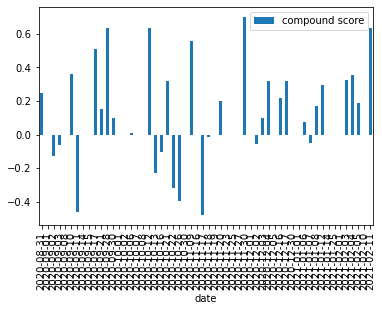

In [143]:
mean_df.plot(kind = 'bar')
plt.show()